# Generating composite images <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one.

Some methods for generating composites include estimating the `median`, `mean`, `minimum`, or `maximum` pixel values in an image.
Care must be taken with these, as they do not necessarily preserve spectral relationships across bands. 
To learn how to generate a composite that does preserve these relationships, see the [Generating geomedian composites notebook](Generating_geomedian_composites.ipynb).

## Description
This notebook demonstrates how to generate a number of different composites from satellite images, and discusses the uses of each.
Specifically, this notebook demonstrates how to generate:

1. Median composites
2. Mean composites
3. Minimum and maximum composites
4. Nearest-time composites

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import sys
import xarray as xr

sys.path.append('../Scripts')
from deafrica_plotting import rgb
from deafrica_datahandling import load_ard, mostcommon_crs, first, last, nearest
from deafrica_bandindices import calculate_indices


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Generating_composites')

## Load Sentinel-2 data

Here we load a timeseries of cloud-masked Sentinel-2 satellite images through the datacube API using the [load_ard](Using_load_ard.ipynb) function.

In [3]:
# Set the area of interest
lat, lon = 14.970, -4.127
buffer = 0.075

# Create a reusable query
query = {
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'time': ('2019'),
    'measurements': ['green', 'red', 'blue', 'nir'],
    'resolution': (-20, 20),
    'group_by': 'solar_day'
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)

# Load available data
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              output_crs=output_crs,
              align=(15, 15),
              **query)

# Print output data
print(ds)


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 71 time steps
<xarray.Dataset>
Dimensions:      (time: 71, x: 812, y: 835)
Coordinates:
  * x            (x) float64 3.707e+05 3.707e+05 ... 3.869e+05 3.869e+05
  * y            (y) float64 1.664e+06 1.664e+06 ... 1.647e+06 1.647e+06
  * time         (time) datetime64[ns] 2019-01-03T10:56:58 ... 2019-12-29T10:56:59
    spatial_ref  int32 32630
Data variables:
    green        (time, y, x) float32 1706.0 1698.0 1897.0 ... 1660.0 1626.0
    red          (time, y, x) float32 2065.0 2145.0 2359.0 ... 1727.0 2139.0
    blue         (time, y, x) float32 1149.0 1168.0 1308.0 ... 742.0 838.0 949.0
    nir          (time, y, x) float32 3329.0 3334.0 3436.0 ... 4147.0 3865.0
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref


## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a series of timesteps. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

The code below will plot four timesteps of the time series we just loaded.

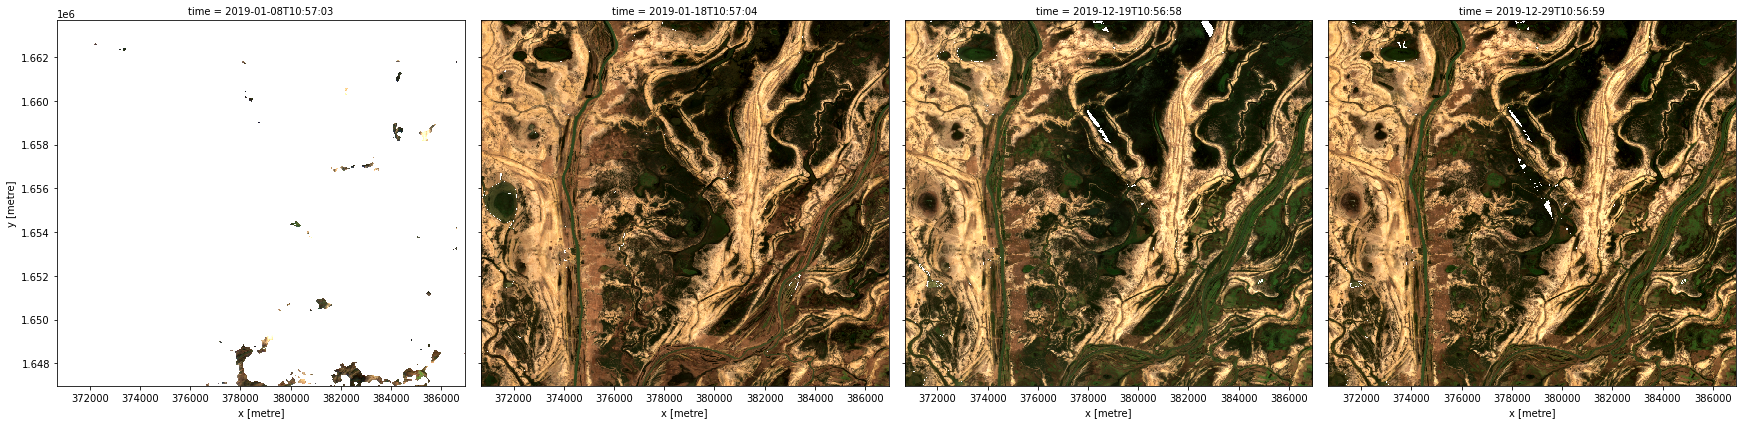

In [4]:
# Set the timesteps to visualise
timesteps = [1, 3, -3, -1]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)

## Median composites

One of the key reasons for generating a composite is to replace pixels classified as clouds with realistic values from the available data. 
This results in an image that doesn't contain any clouds.
In the case of a median composite, each pixel is selected to have the median (or middle) value out of all possible values.

Care should be taken when using these composites for analysis, since the relationships between spectral bands are not preserved.
These composites are also affected by the timespan they're generated over.
For example, the median pixel in a single season may be different to the median value for the whole year.

### Generating a single composite from all data

To generate a single median composite, we use the `xarray.median` method, specifying `'time'` as the dimension to compute the median over.

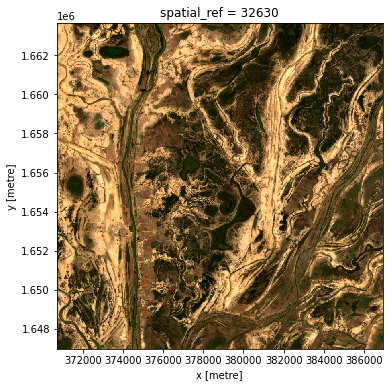

In [5]:
# Compute a single median from all data
ds_median = ds.median('time')

# View the resulting median
rgb(ds_median, bands=['red', 'green', 'blue'])

### Generating multiple composites based on length of time
Rather than using all the data to generate a single median composite, it's possible to use the `xarray.resample` method to group the data into smaller time-spans and generate medians for each of these.
Some resampling options are
* `'nD'` - number of days (e.g. `'7D'` for seven days)
* `'nM'` - number of months (e.g. `'6M'` for six months)
* `'nY'` - number of years (e.g. `'2Y'` for two years)

If the area is particularly cloudy during one of the time-spans, there may still be masked pixels that appear in the median.
This will be true if that pixel is always masked.

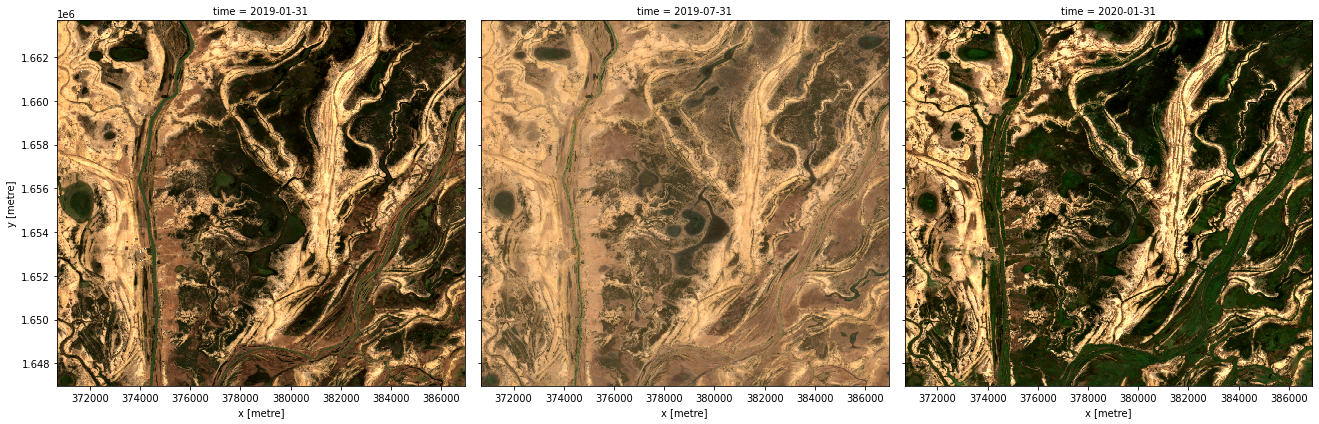

In [6]:
# Generate a median by binning data into six-monthly time-spans
ds_resampled_median = ds.resample(time='6M').median('time')

# View the resulting medians
rgb(ds_resampled_median, bands=['red', 'green', 'blue'], col='time')

### Group By
Similar to resample, grouping works by looking at part of the date, but ignoring other parts. For instance, `'time.month'` would group together all January data together, no matter what year it is from.

Some examples are:
 * `'time.day'` - groups by the day of the month (1-31)
 * `'time.dayofyear'` - groups by the day of the year (1-365)
 * `'time.week'` - groups by week (1-52) 
 * `'time.month'` - groups by the month (1-12)
 * `'time.season'` - groups into 3-month seasons:
     - `'DJF'` December, Jaunary, February
     - `'MAM'` March, April, May
     - `'JJA'` June, July, August
     - `'SON'` September, October, November
 * `'time.year'` - groups by the year

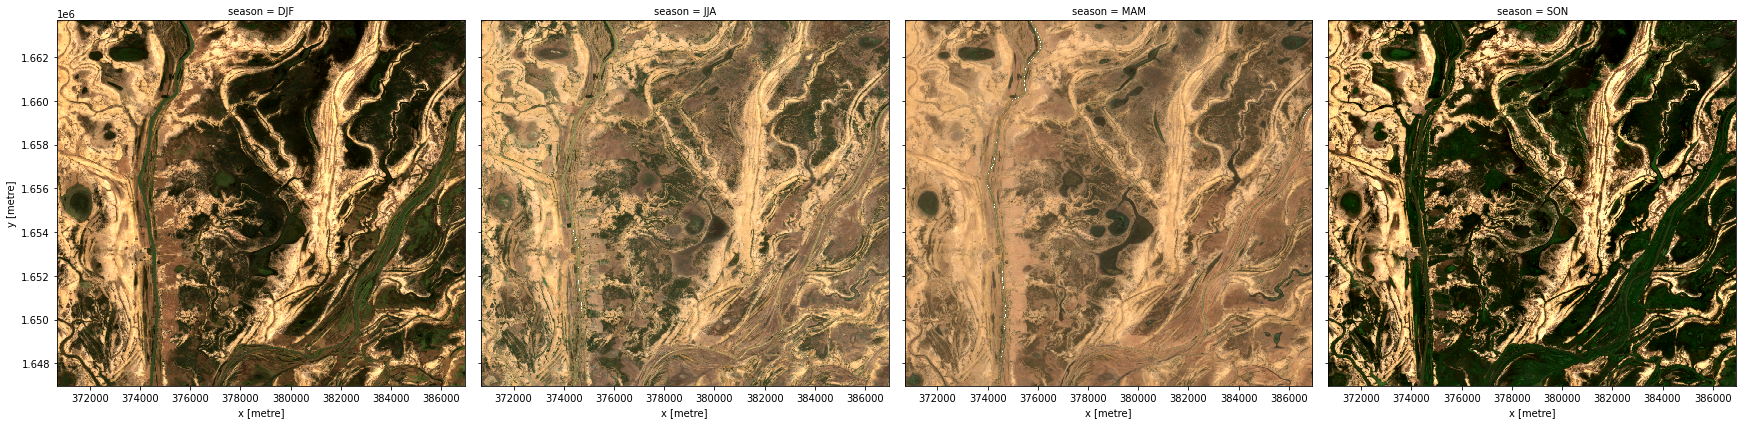

In [7]:
# Generate a median by binning data into six-monthly time-spans
ds_groupby_season = ds.groupby('time.season').median()

# View the resulting medians
rgb(ds_groupby_season, bands=['red', 'green', 'blue'], col='season')

## Mean composites

Mean composites involve taking the average value for each pixel, rather than the middle value as is done for a median composite.
Unlike the median, the mean composite can contain pixel values that were not part of the original dataset.
Care should be taken when interpreting these images, as extreme values (such as unmasked cloud) can strongly affect the mean.

### Generating a single composite from all data

To generate a single mean composite, we use the `xarray.mean` method, specifying `'time'` as the dimension to compute the mean over.

> **Note**: If there are no valid values for a given pixel, you may see the warning:
`RuntimeWarning: Mean of empty slice`. The composite will still be generated, but may have blank areas.

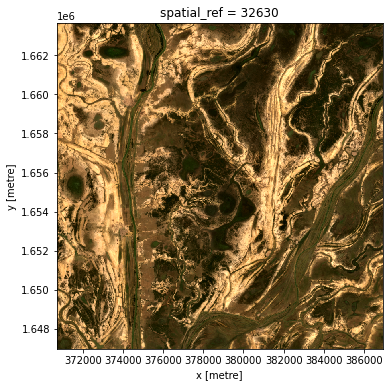

In [8]:
# Compute a single mean from all data
ds_mean = ds.mean('time')

# View the resulting mean
rgb(ds_mean, bands=['red', 'green', 'blue'])

### Generating multiple composites based on length of time
As with the median composite, it's possible to use the `xarray.resample` method to group the data into smaller time-spans and generate means for each of these.
See the previous section for some example resampling time-spans.

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


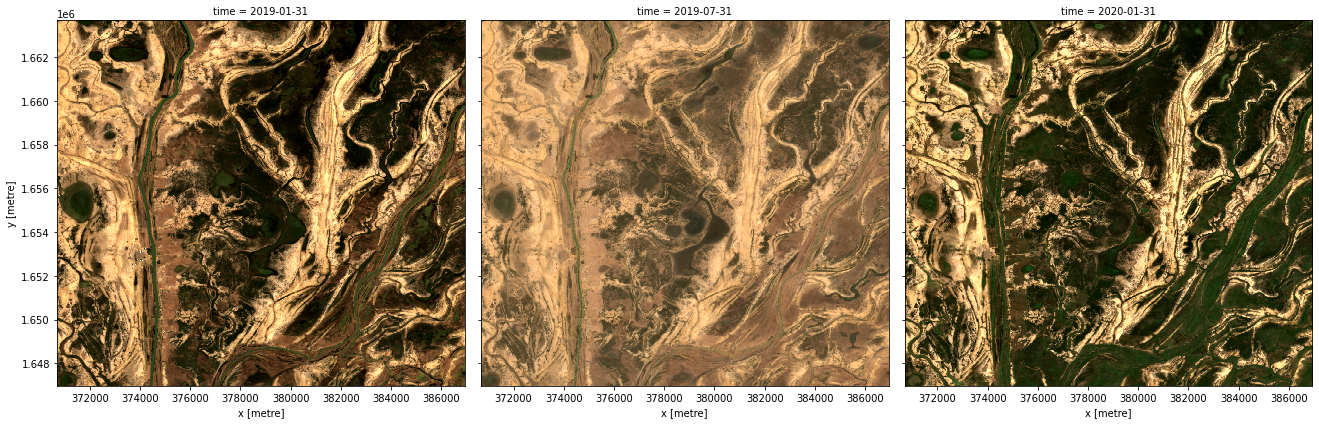

In [9]:
# Generate a mean by binning data into six-monthly time-spans
ds_resampled_mean = ds.resample(time='6M').mean('time')

# View the resulting medians
rgb(ds_resampled_mean, bands=['red', 'green', 'blue'], col='time')

## Minimum and maximum composites

These composites can be useful for identifying extreme behaviour in a collection of satellite images.

For example, comparing the maximum and minimum composites for a given band index could help identify areas that take on a wide range of values, which may indicate areas that have high variability over the time-line of the composite.

To demonstrate this, we start by calculating the normalised difference vegetation index (NDVI) for our data, which can then be used to generate the maximum and minimum composites.

In [10]:
# Start by calculating NDVI
ds = calculate_indices(ds, index='NDVI', collection='c1')

### Maximum composite

To generate a single maximum composite, we use the `xarray.max` method, specifying `'time'` as the dimension to compute the maximum over.

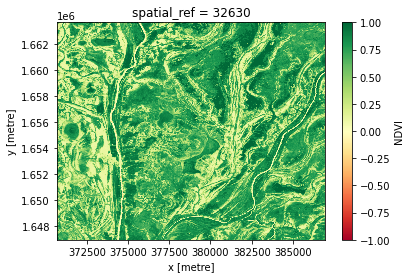

In [11]:
# Compute the maximum composite
ds_max = ds.NDVI.max('time')

# View the resulting composite
ds_max.plot(vmin=-1, vmax=1, cmap='RdYlGn');

### Minimum composite

To generate a single minimum composite, we use the `xarray.min` method, specifying `'time'` as the dimension to compute the minimum over.

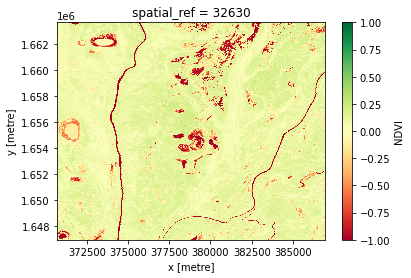

In [12]:
# Compute the minimum composite
ds_min = ds.NDVI.min('time')

# View the resulting composite
ds_min.plot(vmin=-1, vmax=1, cmap='RdYlGn');

## Nearest-time composites

To get an image at a certain time, often there is missing data, due to clouds and other masking.  We can fill in these gaps by using data from surrounding times.

To generate these images, we can use the custom functions `first`, `last` and `nearest` from the [deafrica_datahandling](../Scripts/deafrica_datahandling.py#716) script.

You can also use the in-built `.first()` and `.last()` methods when doing `groupby` and `resample` as described above. They are described in the [xarray documentation](http://xarray.pydata.org/en/stable/groupby.html#first-and-last) on grouped data.

### Most-recent composite

Sometime we may want to determine what the landscape looks like by examining the most recent image.  If we look at the last image for our dataset, we can see there is some missing data in the top-left of the last image.

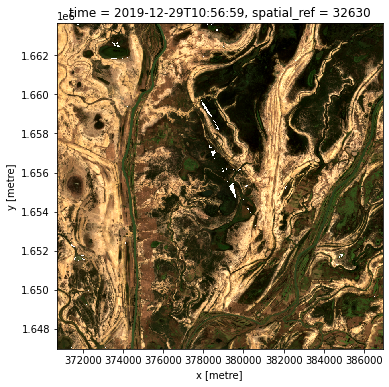

In [13]:
# Plot the last 5 images in time
rgb(ds, index=[-1], col_wrap=5)

We can calculate how much of the data is missing in this most recent image

In [14]:
last_blue_image = ds.blue.isel(time=-1)

precent_valid_data = float(last_blue_image.count() / last_blue_image.size) * 100
print(f"The last image contains {precent_valid_data:.2f}% data.")

The last image contains 99.80% data.


In order to fill in the gaps and produce a complete image showing the most-recent satellite acquistion for every pixel, we can run the `last` function on one of the arrays.

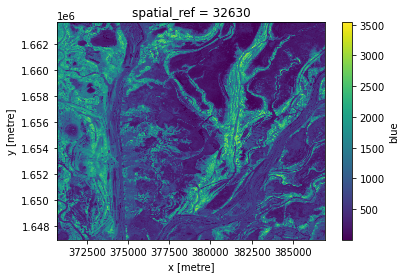

In [15]:
last_blue = last(ds.blue, dim='time')
last_blue.plot();

An easy way to run this function on all bands is to use the `apply` method.

Here we use `apply` to run `last` along the time dimension for every band to fill in the missing data.

In [18]:
# Generate a composite with the latest value available for each pixel
# .apply runs the 'last' function on each of the DataArray bands in the dataset.
ds_latest = ds.apply(last, dim='time')

# View the resulting composite
rgb(ds_latest, bands=['red', 'green', 'blue'])

MergeError: conflicting values for variable 'time' on objects to be combined. You can skip this check by specifying compat='override'.

To see how recent each pixel is, we can compare the age of the pixels with the latest value we have.

Here we can see that most pixels were from the last time slice, although there are some that were much older.

In [ ]:
last_time = ds.time[-1]

# Compare the timestamps and convert them to number of days for plotting.
num_days_old = (last_time - ds_latest.time).dt.days
num_days_old.plot(cmap='plasma', levels=7, figsize=(6,6));

### Before and after composites

Often it is useful to view images before and after an event, to see the change that has occured.

To generate a composite on either side of an event, we can split the dataset along time.

We can then view the composite `last` image before the event, and the composite `first` image after the event.

In [ ]:
# Dates here are inclusive. Use None to not set a start or end of the range.
before_event = slice(None, '2017-06-01')
after_event = slice('2017-06-03', None)

# Select the time period and run the last() or first() function on every band.
ds_before = ds.sel(time=before_event).apply(last, dim='time')
ds_after = ds.sel(time=after_event).apply(first, dim='time')

The composite image before the event, up to 2017-06-01:

In [ ]:
rgb(ds_before, bands=['red', 'green', 'blue'])

The composite image after the event, from 2017-06-03:

In [ ]:
rgb(ds_after, bands=['red', 'green', 'blue'])

### Nearest time composite

Sometimes we just want the closest availible data to a particular point in time. This composite will take values from before _or_ after the specified time to find the nearest observation.

In [ ]:
ds_nearest = ds.apply(nearest, dim='time', target='2017-06-03')
rgb(ds_nearest, bands=['red', 'green', 'blue'])

By looking at the `time` for each pixel, we can see if the pixel was taken from before or after the target time.

In [ ]:
target_datetime = ds_nearest.time.dtype.type('2017-06-03')

(ds_nearest.time - target_datetime).dt.days.plot(cmap='bwr', levels=7, figsize=(6,6));

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** June 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)